In [1]:
import geopandas as gpd
import pandas as pd
import pickle
from tools import plot_current_state_of_graph

In [2]:
path = "/home/datasets4/stein/rivers/processed_recreation/"

In [3]:
meta = pd.read_csv(path + "saxony_flood_meta_data.csv", index_col=0)

In [4]:
data = pd.read_csv(path + "saxony_flood_processed.csv", index_col=0)

In [5]:
G = pickle.load(open(path + "station_G.p", "rb"))

In [6]:
meta.rename(index={
    501060:5010600,
    501110:5011100,
    501261:5012601
    }, inplace=True)
# ID slightly off as these are from another data source.

In [7]:
data.rename(columns={
    "501060_s":"5010600_s",
    "501110_s":"5011100_s",
    "501261_s":"5012601_s"
    }, inplace=True)
# ID slightly off as these are from another data source.

In [8]:
# This file is only created later. Rearange the ordering here.
meta_eg = pd.read_csv("product/rivers_meta_east_germany.csv", index_col=0)

In [9]:
meta.loc[[x for x in meta.index if "id_" + str(x) not in meta_eg["original_id"].values]]

,R,X,Y,D,H,QD,QH,QX,QY,QR
ID,,,,,,,,,,


In [10]:
relevant = meta_eg.loc[meta_eg["original_id"].isin("id_" + meta.index.astype(str))]

In [11]:
# outside
relevant.drop(index=[1150,697], inplace=True)

/tmp/ipykernel_414214/1582659419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant.drop(index=[1150,697], inplace=True)


In [12]:
data = data[[x[3:] + "_s" for x in relevant.original_id]]

In [13]:
flood_graph = G.subgraph(relevant.index)

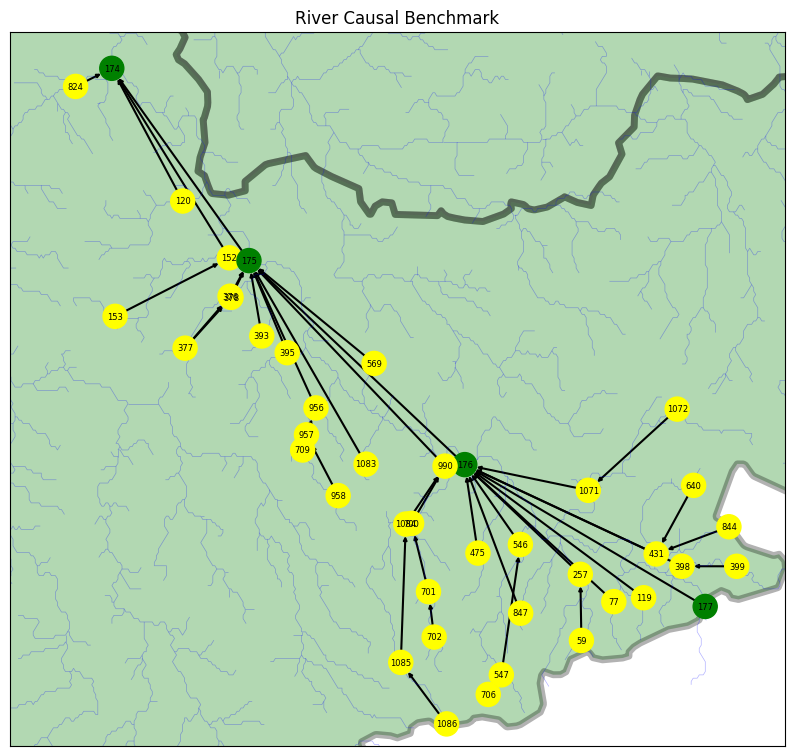

In [14]:
# Full Graph
plot_current_state_of_graph(
    flood_graph,
    dpi=500,
    lim=(50.7, 51.6),
    limx=(12.8, 14.4),
    node_size=300,
    save=0,
    river_map=True,
    hardcode_colors= ["green" if (relevant.loc[x, "R"] == "Elbe") else "yellow" for x in flood_graph.nodes],
    ger_map=True,
    width=1.5,
    arrowsize=5,
    fs=(10, 10),
    font_size=6,
    ger_path = "product/east_german_map.shp",
    river_path = "product/river_east_german_map.shp",
)

In [15]:
import copy
pickle.dump(flood_graph.copy(),open('product/rivers_flood.p', 'wb'))

In [16]:
rename = []
for y in  [x[:-2]  for x in data.columns]:
    rename.append(meta_eg[meta_eg["original_id"].str.contains(y)].index[0])

In [17]:
data.columns = rename

In [18]:
import numpy as np

In [19]:
np.all(relevant.index == sorted(list(flood_graph.nodes))),np.all(data.columns == sorted(list(flood_graph.nodes)))

(np.True_, np.True_)

In [20]:
relevant.to_csv("product/rivers_meta_flood.csv")
data.to_csv("product/rivers_ts_flood.csv")

### Prep a map for this as well i guess

In [21]:
# We have data for all states if this will become necessary in the future.
country_index,naming = [12], "saxony"

<Axes: >

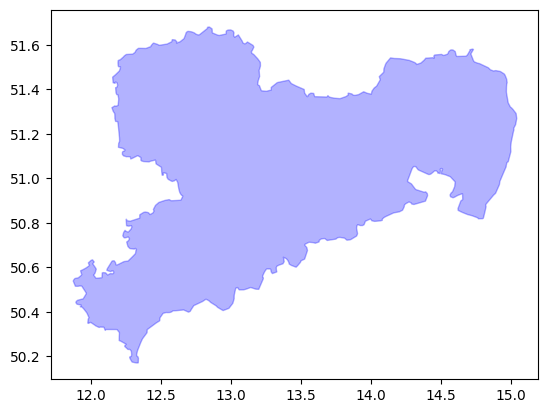

In [22]:
fp =  "visualization/geomaps/vg2500_bld.shp"
map_df = gpd.read_file(fp)
map_df = map_df.loc[country_index]
map_df.plot(color="blue", alpha=0.3, linewidth=1, edgecolor='blue')

In [23]:
# This loads a bit
fp =  "visualization/HydroRIVERS_v10_eu_shp/HydroRIVERS_v10_eu.shp"
r_df = gpd.read_file(fp)
#r_df.plot(color="blue", alpha=0.3, linewidth=1, edgecolor='blue')

In [24]:
# Different filter to check all relevant rivers that match with the state template.
crossings = []
for x in map_df.index:
    crossings.append(map_df.loc[x, "geometry"].boundary.crosses(r_df.loc[:, "geometry"]))
crossings = r_df[pd.concat(crossings,axis=1).any(axis=1)]

In [25]:
contains = []
for x in map_df.index:
    contains.append(map_df.loc[x, "geometry"].contains(r_df.loc[:, "geometry"]))
contains = r_df[pd.concat(contains,axis=1).any(axis=1)]

In [26]:
intersect = []
for x in map_df.index:
    intersect.append(map_df.loc[x, "geometry"].contains(r_df.loc[:, "geometry"]))
intersect = r_df[pd.concat(intersect,axis=1).any(axis=1)]

<Axes: >

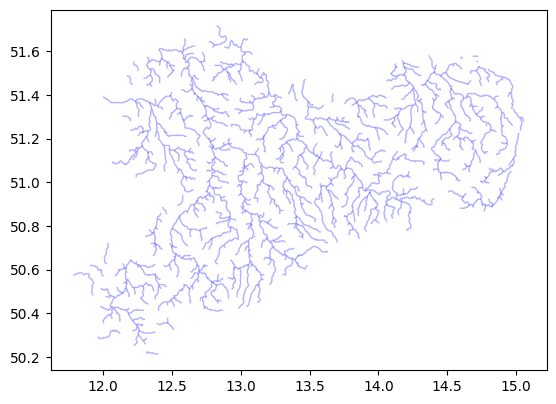

In [27]:
pd.concat([crossings, contains,intersect]).drop_duplicates(subset = "HYRIV_ID").plot(alpha=0.3, linewidth=1, edgecolor='blue')

In [28]:
pd.concat([crossings, contains,intersect]).drop_duplicates(subset = "HYRIV_ID").to_file("product/river_" + naming + "_map.shp")

In [29]:
map_df.to_file("product/" + naming + "_map.shp")

/home/stein/anaconda3/envs/causal_rivers_construction/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 18401642456.2639008 of field SHAPE_AREA of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
